# Рекуррентные нейронные сети (RNNs)

In [8]:
!wget http://opencorpora.org/files/export/annot/annot.opcorpora.xml.byfile.zip

--2021-11-21 13:36:49--  http://opencorpora.org/files/export/annot/annot.opcorpora.xml.byfile.zip
Resolving opencorpora.org (opencorpora.org)... 46.4.87.221
Connecting to opencorpora.org (opencorpora.org)|46.4.87.221|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58737302 (56M) [application/zip]
Saving to: ‘annot.opcorpora.xml.byfile.zip’

annot.opcorpora.xml 100%[===================>]  56.02M  15.5MB/s    in 3.7s    

2021-11-21 13:36:53 (15.1 MB/s) - ‘annot.opcorpora.xml.byfile.zip’ saved [58737302/58737302]



In [10]:
from corus import load_corpora
import tqdm

path = 'annot.opcorpora.xml.byfile.zip'
records = load_corpora(path)

with open('pos_data.txt', 'w', encoding='utf8') as f:
    for rec in tqdm.tqdm(records):
        for par in rec.pars:
            for sent in par.sents:
                for token in sent.tokens:
                    f.write(f'{token.text} {token.forms[0].grams[0]}\n')
                f.write('\n')

4007it [02:00, 33.12it/s] 


In [57]:
data = open('pos_data.txt').read().strip().split('\n\n')
data = [s.split('\n') for s in data]
for s in data:
    for i, tok in enumerate(s):
        s[i] = tok.split()
        

In [58]:
len(data)

110304

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(42)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling или token classification (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

Будем решать POS Tagging для русского и сравним с тэггером из HW3 прошлогоднего курса по Python

Пример размеченного предложения:

In [59]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

Коморовский    	UNKN
солидарен      	ADJS
с              	PREP
Туском         	NOUN
в              	PREP
оценке         	NOUN
отчёта         	NOUN
МАК            	NOUN


Построим разбиение на train/val/test

на train будем учиться

на val - подбирать параметры и делать всякие early stopping

на test - принимать модель по ее финальному качеству.

In [60]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 1271895
Words count in val set: 222203
Words count in test set: 495440


Построим маппинги из слов в индекс и из тега в индекс:


In [61]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 151144. Tags = {'DATE', 'HANI', 'TIME', 'NOUN', 'PRTF', 'COMP', 'PRED', 'GREK', 'VERB', 'GRND', 'PRTS', 'PRCL', 'UNKN', 'INFN', 'PNCT', 'LATN', 'CONJ', 'SYMB', 'NPRO', 'NUMB', 'PREP', 'ADVB', 'ADJF', 'NUMR', 'ROMN', 'INTJ', 'ADJS'}


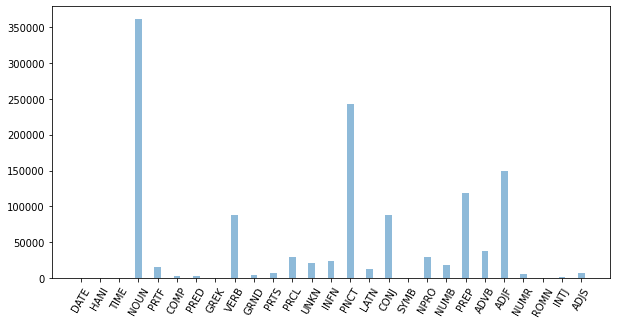

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags, rotation=60)
    
plt.show()

## Бейзлайн


Импортируйте и обучите старый тэггер из HW3 с прошлого курса (необязательно, но желательно)

## Добавляем контекст с рекуррентными сетями

Полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [66]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

Для работы с датасетом в PyTorch воспользуемся классами Dataset и DataLoader.

В наследнике Dataset объявим методы __init__, __len__ и __getitem__

DataLoader позволит итерироваться батчами по объекту этого класса

In [86]:
from torch.utils.data import Dataset, DataLoader

In [87]:
class PartOfSpeechData(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return (self.X[idx], self.y[idx])

In [146]:
train_data = PartOfSpeechData(X_train, y_train)
val_data = PartOfSpeechData(X_val, y_val)
test_data = PartOfSpeechData(X_test, y_test)

При объявлении DataLoader необходимо передать параметр "collate_fn" -- самописную функцию, которая принимает сырой батч (два списка списков) и возвращает сформированные тензоры.

Поскольку предложения разной длины, необходимо заполнить нулевыми токенами короткие предложения (pad_sequence), чтобы можно было сделать stack.

Функция collate_fn как раз для этого



In [278]:
from torch.nn.utils.rnn import pad_sequence

# Поскольку предложения в наших данных разной длины, нам необходима функция, которая приведет батч к тензору,
# заполнив короткие предложения pad'ами.
def collate_fn(batch):
    data = pad_sequence([torch.LongTensor(item[0]) for item in batch])
    target = pad_sequence([torch.LongTensor(item[1]) for item in batch])
    return [data, target]

In [279]:
X_batch, y_batch = next(iter(DataLoader(train_data, batch_size=4, collate_fn=collate_fn)))

In [280]:
(X_batch.shape, y_batch.shape)

(torch.Size([29, 4]), torch.Size([29, 4]))

**Задание** Реализуйте `LSTMTagger`:

In [233]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128):
        super().__init__()
        
        self.emb = None
        self.lstm = None
        self.linear = None

    def forward(self, sentence):
        return

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [238]:
def accuracy():
    pass


model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

z = model(X_batch[:, 0])

loss = None

**Задание** Вставьте эти вычисление в функцию:

Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

In [282]:
import tqdm

train_loader = None
val_loader = None


epochs = 5
lr = 2e-5

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer= optim.SGD(model.parameters(), lr=lr)

# Лучше всего работать в google colab на видеокарте
# Для этого раскомментируйте строчки

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# На девайс таким же образом необходимо будет переместить вектора примеров и ответов перед расчетами


# Помимо непосредственно обучения реализуйте:

# 1) Аккумулирование лосса в течение всех примеров в батче, а градиентный шаг только в конце
# 2) Динамический показ в tqdm значения среднего лосса на последних 5000 итерациях (можно использовать SMA)
# Для показа используйте метод tqdm set_description
# 3) Сбор данных по лоссу на train и val
# 4) Отображение лосса графике

model.train()

for e in tqdm.tqdm(range(epochs)):
    
    for X_batch, y_batch in tqdm.tqdm(train_loader):

        for i in range(X_batch.shape[1]-1):
            pass
        

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!